Chinese Government Bond Data:
Maturity: 0.25 years, Yield: 1.38%
Maturity: 0.50 years, Yield: 1.38%
Maturity: 1.00 years, Yield: 1.40%
Maturity: 3.00 years, Yield: 1.43%
Maturity: 5.00 years, Yield: 1.49%
Maturity: 7.00 years, Yield: 1.60%
Maturity: 10.00 years, Yield: 1.66%
Maturity: 30.00 years, Yield: 1.86%

Fitting Nelson-Siegel model...

Fitting Cubic Spline model...


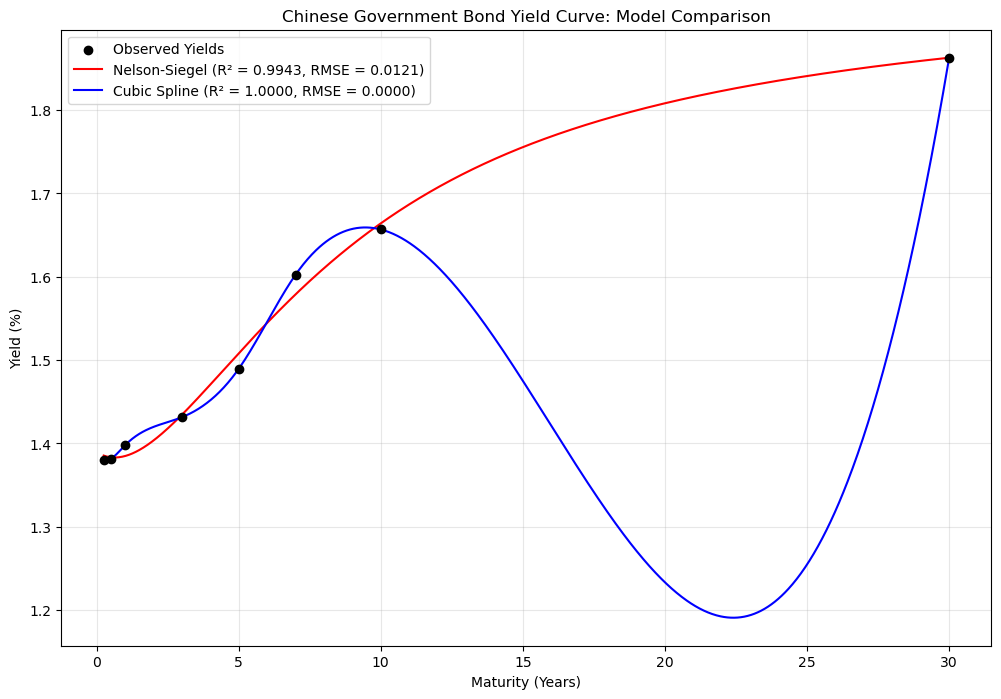


Model Comparison:
Metric          Nelson-Siegel   Cubic Spline   
---------------------------------------------
R-squared       0.9943          1.0000         
RMSE            0.0121          0.0000         

Nelson-Siegel Parameters:
beta0: 1.9729 - Long-term rate (level)
beta1: -0.5831 - Short-term component (slope)
beta2: -0.6955 - Medium-term component (curvature)
tau: 2.5815 - Decay factor

Cubic Spline:
Number of knots: 8
Number of coefficients: 7

Model Interpretations:
Nelson-Siegel: A parametric model that provides economic interpretation of the yield curve shape.
Cubic Spline: A non-parametric model that provides excellent fit but limited economic interpretation.


In [1]:
# Yield Curve Modeling for Chinese Government Securities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import CubicSpline
import requests
from io import StringIO

def fetch_chinese_govt_bonds():
    """
    Function to fetch Chinese government bond yield data.
    In a real implementation, you would use an API like:
    - Wind Financial Terminal API
    - Bloomberg API
    - CEIC Data
    - China Bond Data
    """
    
    # For this exercise, We use 2025/04/11 data from pbc.gov.cn
    maturities = np.array([0.25, 0.5, 1, 3, 5, 7, 10, 30])  # in years
    yields = np.array([1.38, 1.3816, 1.3978, 1.4315, 1.4895, 1.6024, 1.6568, 1.8627])  # in percentage
    
    return pd.DataFrame({'maturity': maturities, 'yield': yields})

def nelson_siegel(params, maturities):
    """
    Calculate yields using the Nelson-Siegel model.
    
    Parameters:
    params: List of parameters [beta0, beta1, beta2, tau]
    maturities: Array of maturities in years
    
    Returns:
    Array of yields
    """
    beta0, beta1, beta2, tau = params
    
    if tau <= 0:
        return np.ones(len(maturities)) * 1e10
    
    factor1 = np.ones_like(maturities)
    factor2 = (1 - np.exp(-maturities / tau)) / (maturities / tau)
    factor3 = (1 - np.exp(-maturities / tau)) / (maturities / tau) - np.exp(-maturities / tau)
    
    y = beta0 * factor1 + beta1 * factor2 + beta2 * factor3
    
    return y

def ns_objective(params, maturities, observed_yields):
    """
    Objective function for Nelson-Siegel model optimization.
    
    Parameters:
    params: List of parameters [beta0, beta1, beta2, tau]
    maturities: Array of maturities in years
    observed_yields: Observed market yields
    
    Returns:
    Sum of squared errors
    """
    predicted_yields = nelson_siegel(params, maturities)
    return np.sum((predicted_yields - observed_yields) ** 2)

def fit_nelson_siegel(maturities, yields):
    """
    Fit the Nelson-Siegel model to yield curve data.
    
    Parameters:
    maturities: Array of maturities in years
    yields: Observed market yields
    
    Returns:
    Optimal parameters and model information
    """
    initial_params = [yields[-1], yields[0] - yields[-1], 0, 1.0]
    
    bounds = [(None, None), (None, None), (None, None), (0.1, None)]
    
    result = minimize(
        ns_objective, 
        initial_params, 
        args=(maturities, yields), 
        bounds=bounds,
        method='L-BFGS-B'
    )
    
    optimal_params = result.x
    
    fitted_yields = nelson_siegel(optimal_params, maturities)
    
    residuals = yields - fitted_yields
    sse = np.sum(residuals ** 2)
    sst = np.sum((yields - np.mean(yields)) ** 2)
    r_squared = 1 - (sse / sst)
    rmse = np.sqrt(np.mean(residuals ** 2))
    
    interpretations = {
        'beta0': f"{optimal_params[0]:.4f} - Long-term rate (level)",
        'beta1': f"{optimal_params[1]:.4f} - Short-term component (slope)",
        'beta2': f"{optimal_params[2]:.4f} - Medium-term component (curvature)",
        'tau': f"{optimal_params[3]:.4f} - Decay factor"
    }
    
    return {
        'params': optimal_params,
        'fitted_yields': fitted_yields,
        'r_squared': r_squared,
        'rmse': rmse,
        'interpretations': interpretations
    }

def fit_cubic_spline(maturities, yields):
    """
    Fit a cubic spline model to yield curve data.
    
    Parameters:
    maturities: Array of maturities in years
    yields: Observed market yields
    
    Returns:
    Fitted spline model and metrics
    """
    cs = CubicSpline(maturities, yields)
    
    fitted_yields = cs(maturities)
    
    residuals = yields - fitted_yields
    sse = np.sum(residuals ** 2)
    sst = np.sum((yields - np.mean(yields)) ** 2)
    r_squared = 1 - (sse / sst)
    rmse = np.sqrt(np.mean(residuals ** 2))
    
    coefficients = cs.c
    
    return {
        'spline': cs,
        'fitted_yields': fitted_yields,
        'r_squared': r_squared,
        'rmse': rmse,
        'coefficients': coefficients
    }

def compare_models(maturities, yields, ns_results, cs_results):
    """
    Compare Nelson-Siegel and Cubic Spline models and visualize results.
    
    Parameters:
    maturities: Array of maturities in years
    yields: Observed market yields
    ns_results: Results from Nelson-Siegel model
    cs_results: Results from Cubic Spline model
    """
    fine_maturities = np.linspace(maturities.min(), maturities.max(), 1000)
    
    ns_smooth = nelson_siegel(ns_results['params'], fine_maturities)
    cs_smooth = cs_results['spline'](fine_maturities)
    
    plt.figure(figsize=(12, 8))
    
    plt.scatter(maturities, yields, color='black', label='Observed Yields', zorder=5)
    
    plt.plot(fine_maturities, ns_smooth, 'r-', label=f'Nelson-Siegel (R² = {ns_results["r_squared"]:.4f}, RMSE = {ns_results["rmse"]:.4f})')
    plt.plot(fine_maturities, cs_smooth, 'b-', label=f'Cubic Spline (R² = {cs_results["r_squared"]:.4f}, RMSE = {cs_results["rmse"]:.4f})')
    
    plt.xlabel('Maturity (Years)')
    plt.ylabel('Yield (%)')
    plt.title('Chinese Government Bond Yield Curve: Model Comparison')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.savefig('yield_curve_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nModel Comparison:")
    print(f"{'Metric':<15} {'Nelson-Siegel':<15} {'Cubic Spline':<15}")
    print("-" * 45)
    print(f"{'R-squared':<15} {ns_results['r_squared']:<15.4f} {cs_results['r_squared']:<15.4f}")
    print(f"{'RMSE':<15} {ns_results['rmse']:<15.4f} {cs_results['rmse']:<15.4f}")
    
    print("\nNelson-Siegel Parameters:")
    for param, interp in ns_results['interpretations'].items():
        print(f"{param}: {interp}")
    
    print("\nCubic Spline:")
    print(f"Number of knots: {len(maturities)}")
    print(f"Number of coefficients: {cs_results['coefficients'].shape[1]}")

if __name__ == "__main__":
    bond_data = fetch_chinese_govt_bonds()
    maturities = bond_data['maturity'].values
    yields = bond_data['yield'].values
    
    print("Chinese Government Bond Data:")
    for i in range(len(maturities)):
        print(f"Maturity: {maturities[i]:.2f} years, Yield: {yields[i]:.2f}%")
    
    print("\nFitting Nelson-Siegel model...")
    ns_results = fit_nelson_siegel(maturities, yields)
    
    print("\nFitting Cubic Spline model...")
    cs_results = fit_cubic_spline(maturities, yields)
    
    compare_models(maturities, yields, ns_results, cs_results)
    
    print("\nModel Interpretations:")
    print("Nelson-Siegel: A parametric model that provides economic interpretation of the yield curve shape.")
    print("Cubic Spline: A non-parametric model that provides excellent fit but limited economic interpretation.")